In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import Perceval and Scaleway provider
import perceval as pcvl
import perceval.providers.scaleway as scw

# Import custom modules (if available)
from boson_sampler import BosonSampler
from utils import MNIST_partial, plot_training_metrics

import keras
import tensorflow as tf

In [21]:
# Set Scaleway project credentials (replace with actual values or ensure environment is set)
os.environ["SCW_PROJECT_ID"] = "5303a5ba-7e81-41a8-bcaf-937620e6dea6"
os.environ["SCW_SECRET_KEY"] = "7ec92326-858b-4275-b147-2e09351fbde9"

scw_project_id = os.environ.get("SCW_PROJECT_ID")
scw_token = os.environ.get("SCW_SECRET_KEY")
if scw_project_id is None or scw_token is None:
    raise ValueError("Please set SCW_PROJECT_ID and SCW_SECRET_KEY environment variables.")

def create_session():
    s = scw.Session(
        project_id=scw_project_id,
        token=scw_token,
        platform="sim:sampling:l4",
        max_idle_duration_s=4800,
        max_duration_s=10800,
        deduplication_id="my-photonic-session-pool"
    )
    s.start()
    return s

num_sessions = 14

sessions = [create_session() for _ in range(num_sessions)]
print("Scaleway session started.")


Scaleway session started.


In [22]:
sessions

In [23]:
# Define dataset paths (assuming MNIST .npy files are available)
root_path = "/Users/soardr/Desktop/Perceval/Photonic Kernel/data original"  # Update to the actual data directory
raw_train_path = os.path.join(root_path, "train_images.npy")
raw_test_path = os.path.join(root_path, "test_images.npy")

raw_train_path, raw_test_path


('/Users/soardr/Desktop/Perceval/Photonic Kernel/data original/train_images.npy',
 '/Users/soardr/Desktop/Perceval/Photonic Kernel/data original/test_images.npy')

In [24]:
# ('/path/to/Photonic Kernel/data/train_images.npy',
#  '/path/to/Photonic Kernel/data/test_images.npy')


In [25]:
# Experiment parameters
n_epochs = 30
n_layers = 7
PREPROCESS = True

np.random.seed(0)


In [26]:
def encoding_layer(data, type=1, kernel_size=2):
    assert data is not None
    if type == 1:
        modes = kernel_size ** 2
    elif type == 2:  # delayed encoding
        modes = kernel_size ** 2
        if (modes % 2) == 1:
            modes += 1
        modes //= 2

    circuit = pcvl.Circuit(modes)

    if type == 1:
        # Encoding each pixel value as a phase shift on a separate mode
        for i, pixel in enumerate(data):
            circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
        # Add beam splitters in a chain to entangle modes
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass

    elif type == 2:
        # Delayed encoding: first half of phase shifts, then BS, then remaining phase shifts
        for i, pixel in enumerate(data):
            if (i % 2) == 0:
                circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        for i, pixel in enumerate(data):
            if (i % 2) == 1:
                circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass

    return circuit, modes

def post_encoding(circuit, modes, depth=2):
    """Apply additional layers of beam splitters to the circuit to increase mixing (entanglement)."""
    # A permutation (here identity) can be applied between layers (placeholder, currently identity)
    perm = list(range(modes))
    circuit.add(0, pcvl.PERM(perm))
    for _ in range(depth - 1):
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        perm = list(range(modes))
        circuit.add(0, pcvl.PERM(perm))
    # Final layer of beam splitters
    for i in range(0, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass
    for i in range(1, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass


In [27]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def generate_quantum_embedding(classical_data, modes=25, depth=2, session=None):
    MAX_EMBEDDING_DIM = 1000

    # Build the encoding circuit and apply additional mixing
    encode_circuit, modes_ret = encoding_layer(classical_data)
    post_encoding(encode_circuit, modes_ret, depth=depth)

    # Try to use remote quantum processor (Scaleway)
    try:
        if session is None:
            raise RuntimeError("No remote session available, using local simulation.")
        processor = session.build_remote_processor()
        processor.set_circuit(encode_circuit)
        # Input state: 10 photons in the first 10 modes (if modes_ret < 10, this will be adjusted below)
        input_state = [1] * min(10, modes_ret) + [0] * max(0, (modes_ret - 10))
        processor.with_input(pcvl.BasicState(input_state))

        n_samples = 1000

        sampler = pcvl.algorithm.Sampler(processor, max_shots_per_call=n_samples)
        job = sampler.probs(n_samples)
        raw_distribution = job.get("results")
        if raw_distribution is None:
            raise ValueError("Remote job returned no results.")
    except Exception as e:
        # If the session is terminated or not available, perform local simulation (simplified)
        if session is not None and "session is terminated" in str(e):
            print("Session terminated. Restarting session...")
            session.start()
            processor = session.build_remote_processor()
            processor.set_circuit(encode_circuit)
            processor.with_input(pcvl.BasicState(input_state))
            sampler = pcvl.algorithm.Sampler(processor, max_shots_per_call=n_samples)
            job = sampler.probs(n_samples)
            raw_distribution = job.get("results")
        else:
            # Local simulation of interference (fallback)
            a, b, c, d = classical_data  # expects a list of 4 pixel values
            # Phase shifts for each pixel
            E0 = complex(np.cos(2*np.pi*a), np.sin(2*np.pi*a))
            E1 = complex(np.cos(2*np.pi*b), np.sin(2*np.pi*b))
            E2 = complex(np.cos(2*np.pi*c), np.sin(2*np.pi*c))
            E3 = complex(np.cos(2*np.pi*d), np.sin(2*np.pi*d))
            # First layer of beam splitters (mix 0-1 and 2-3)
            E0p = (E0 + E1) / np.sqrt(2)
            E1p = (E0 - E1) / np.sqrt(2)
            E2p = (E2 + E3) / np.sqrt(2)
            E3p = (E2 - E3) / np.sqrt(2)
            # Second layer of beam splitters (mix 0'-3' and 1'-2')
            E0pp = (E3p - E0p) / np.sqrt(2)
            E3pp = (E3p + E0p) / np.sqrt(2)
            E1pp = (E1p + E2p) / np.sqrt(2)
            E2pp = (E1p - E2p) / np.sqrt(2)
            # Output "quantum" features as intensities
            I0 = E0pp.real**2 + E0pp.imag**2
            I1 = E1pp.real**2 + E1pp.imag**2
            I2 = E2pp.real**2 + E2pp.imag**2
            I3 = E3pp.real**2 + E3pp.imag**2
            # Use these four features as a simple embedding
            emb_tensor = torch.tensor([I0, I1, I2, I3], dtype=torch.float32)
            return emb_tensor
    
    # print("raw distribution in generate_quantum_embedding:", raw_distribution)

    # If using remote, convert the distribution to an embedding vector
    sorted_keys = sorted(raw_distribution.keys(), key=lambda k: raw_distribution[k], reverse=True)
    # print("sorted_keys in generate_quantum_embedding:", sorted_keys)

    sorted_keys = sorted_keys[:max(MAX_EMBEDDING_DIM, len(sorted_keys))]
    # print("sorted_keys after proc in generate_quantum_embedding:", generate_quantum_embedding)

    embedding_vector = np.zeros(max(MAX_EMBEDDING_DIM, len(sorted_keys)))
    for idx, key in enumerate(sorted_keys):
        embedding_vector[idx] = raw_distribution[key]
    emb_tensor = torch.tensor(embedding_vector, dtype=torch.float32)
    print("Quantum embedding generated with shape:", emb_tensor.shape)
    print("emb_tensor")
    
    return emb_tensor


In [35]:
import concurrent.futures

In [36]:
num_sessions

14

In [75]:
def quanv_inner(image, j, W, out, output_channels, session):
    for k in range(0, W, 2):
        patch = [
            float(image[j, k, 0]),
            float(image[j, k + 1, 0]),
            float(image[j + 1, k, 0]),
            float(image[j + 1, k + 1, 0])
        ]
        # Get quantum embedding for this 2x2 patch
        q_emb = generate_quantum_embedding(patch, session=session)
        q_emb = q_emb.detach().numpy() if torch.is_tensor(q_emb) else np.array(q_emb)
        # print("q_emb in quanv_perceval:", q_emb, q_emb.shape)
        # Use first 4 features for the output feature map
        out[j // 2, k // 2, :output_channels] = q_emb[:output_channels]

In [81]:
def quanv_perceval(image, sessions, local_idx):
    """Apply the photonic quantum convolution to a single image."""
    H, W, C = image.shape
    assert C == 1  # expecting a single-channel (grayscale) image
    output_channels = 20

    out = np.zeros((H // 2, W // 2, output_channels))
    # Slide a 2x2 window across the image with stride 2

    # threading
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
        futures = {executor.submit(quanv_inner, image, i * 2, W, out, output_channels, sessions[i]): i for i in range(num_sessions)}

        # # Collect results
        # for future in concurrent.futures.as_completed(futures):
        #     # print(future.result())
        #     temp = future.result()
        #     q_test_images.append(temp[1])
        #     q_test_labels.append(temp[0])
    
    # for j in range(0, H, 2):
    #     for k in range(0, W, 2):
    #         patch = [
    #             float(image[j, k, 0]),
    #             float(image[j, k + 1, 0]),
    #             float(image[j + 1, k, 0]),
    #             float(image[j + 1, k + 1, 0])
    #         ]
    #         # Get quantum embedding for this 2x2 patch
    #         q_emb = generate_quantum_embedding(patch, session=sessions[j])
    #         q_emb = q_emb.detach().numpy() if torch.is_tensor(q_emb) else np.array(q_emb)
    #         # print("q_emb in quanv_perceval:", q_emb, q_emb.shape)
    #         # Use first 4 features for the output feature map
    #         out[j // 2, k // 2, :output_channels] = q_emb[:output_channels]
    
    return (local_idx, out)


[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4


In [142]:
# # Load the dataset from .npy files
# train_images = np.load(raw_train_path)
# test_images = np.load(raw_test_path)
# # (Optional) Load labels if available
# train_labels_path = os.path.join(root_path, "train_labels.npy")
# test_labels_path = os.path.join(root_path, "test_labels.npy")
# if os.path.exists(train_labels_path):
#     train_labels = np.load(train_labels_path)
#     test_labels = np.load(test_labels_path)
# else:
#     # # If label files are not present, use torchvision to download MNIST labels as a fallback
#     # train_labels = torchvision.datasets.MNIST(root="./data", train=True, download=True).targets.numpy()
#     # test_labels = torchvision.datasets.MNIST(root="./data", train=False, download=True).targets.numpy()

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images
train_labels = train_labels
test_images = test_images
test_labels = test_labels

# Normalize image pixel values to [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0
# Add channel dimension
train_images = train_images[..., np.newaxis]  # shape: (N_train, 28, 28, 1)
test_images = test_images[..., np.newaxis]    # shape: (N_test, 28, 28, 1)

print("Loaded data shapes:", train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)


Loaded data shapes: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [ ]:
# Quantum feature extraction on training and test images
q_train_images = []
q_train_labels = []

q_test_images = []
q_test_labels = []

SAVE_PATH = "./"  # save in current directory or specify a path

# if PREPROCESS:
# for kkk in range(5):
if True:
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        # For demonstration, we limit to a smaller number of images to avoid long runtimes
        if idx >= 33:  # process first 100 images for example
            print("idx:", idx)
            
        # if True:
            if (idx + 1) % 10 == 0:
                print(f"Processed {idx+1}/{len(train_images)} images", end="\r")
            
            temp = quanv_perceval(img, sessions, idx)
            q_train_images.append(temp[1])
            q_train_labels.append(temp[0])

            q_train_images = np.asarray(q_train_images)
            q_train_labels = np.asarray(q_train_labels)

            np.save(SAVE_PATH + "percv_emb_conv_type_1_train_images_cont_" + str(idx) + ".npy", q_train_images)
            np.save(SAVE_PATH + "percv_emb_conv_type_1_train_labels_cont_" + str(idx) + ".npy", q_train_labels)

            q_train_images = []
            q_train_labels = []
        else:
            pass
    
    # for idx in range(0, 100, num_sessions):
    # for idx in range(kkk * num_sessions, (kkk + 1) * num_sessions):
    #     idxs = [idx + __ for __ in range(num_sessions)]
    #     imgs = [train_images[i] for i in idxs]

    #     # threading
    #     with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
    #         futures = {executor.submit(quanv_perceval, imgs[i], sessions[i], idxs[i]): i for i in range(num_sessions)}

    #         # Collect results
    #         for future in concurrent.futures.as_completed(futures):
    #             # print(future.result())
    #             temp = future.result()
    #             q_train_images.append(temp[1])
    #             q_train_labels.append(temp[0])

    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        if idx >= 2:  # process first 20 test images for example
            print("idx:", idx)
        # if True:
            if (idx + 1) % 10 == 0:
                print(f"Processed {idx+1}/{len(test_images)} images", end="\r")
            
            temp = quanv_perceval(img, sessions, idx)
            q_test_images.append(temp[1])
            q_test_labels.append(temp[0])

            q_test_images = np.asarray(q_train_images)
            q_test_labels = np.asarray(q_train_labels)

            np.save(SAVE_PATH + "percv_emb_conv_type_1_test_images_cont_" + str(idx) + ".npy", q_test_images)
            np.save(SAVE_PATH + "percv_emb_conv_type_1_test_labels_cont_" + str(idx) + ".npy", q_test_labels)

            q_test_images = []
            q_test_labels = []
        else:
            pass
    
    # for idx in range(0, 20, num_sessions):
    # for idx in range(kkk * num_sessions, (kkk + 1) * num_sessions):
    #     idxs = [idx + __ for __ in range(num_sessions)]
    #     imgs = [test_images[i] for i in idxs]

    #     # threading
    #     with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
    #         futures = {executor.submit(quanv_perceval, imgs[i], sessions[i], idxs[i]): i for i in range(num_sessions)}

    #         # Collect results
    #         for future in concurrent.futures.as_completed(futures):
    #             # print(future.result())
    #             temp = future.result()
    #             q_test_images.append(temp[1])
    #             q_test_labels.append(temp[0])
    
    # q_test_images = np.asarray(q_test_images)
    # q_test_labels = np.asarray(q_test_labels)

     # Save the quantum-processed images to disk for future use (optional)

    # np.save(SAVE_PATH + "percv_emb_conv_type_1_train_images_" + str(kkk) + ".npy", q_train_images)
    # np.save(SAVE_PATH + "percv_emb_conv_type_1_test_images_" + str(kkk) + ".npy", q_test_images)

#  # Save the quantum-processed images to disk for future use (optional)
# SAVE_PATH = "./"  # save in current directory or specify a path
# np.save(SAVE_PATH + "percv_emb_conv_type_1_train_images.npy", q_train_images)
# np.save(SAVE_PATH + "percv_emb_conv_type_1_test_images.npy", q_test_images)

# np.save(SAVE_PATH + "percv_emb_conv_type_1_train_labels.npy", q_train_labels)
# np.save(SAVE_PATH + "percv_emb_conv_type_1_test_labels.npy", q_test_labels)


Quantum pre-processing of train images:
idx: 33
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use

KeyboardInterrupt: 

Quantum embedding generated with shape: torch.Size([1000])
emb_tensor
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
Quantum embedding generated with shape: torch.Size([1000])
emb_tensor
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
Quantum embedding generated with shape: torch.Size([1000])
emb_tensor
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current

### Reading the embeddings

In [88]:
perc_type1_train_img_emb = np.load("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_images.npy")
perc_type1_test_img_emb = np.load("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_test_images.npy")

In [91]:
perc_type1_train_lbl_emb = np.load("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_labels.npy")
perc_type1_test_lbl_emb = np.load("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_test_labels.npy")

In [90]:
perc_type1_train_img_emb.shape, perc_type1_test_img_emb.shape

((10, 14, 14, 20), (2, 14, 14, 20))

In [92]:
perc_type1_train_lbl_emb.shape, perc_type1_test_lbl_emb.shape

((10,), (2,))

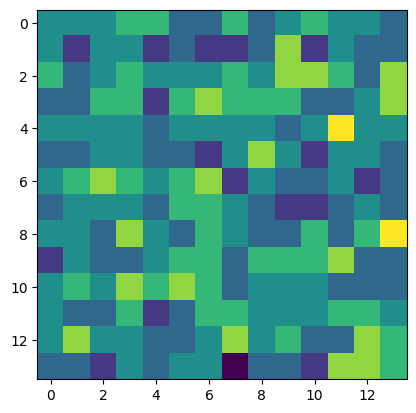

In [98]:
plt.imshow(perc_type1_train_img_emb[9][:, :, 19])

### Dataset creation

In [99]:
train_images = torch.tensor(perc_type1_train_img_emb, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (10, 20, 14, 14)
train_labels = torch.tensor(perc_type1_train_lbl_emb, dtype=torch.long)

In [100]:
test_images = torch.tensor(perc_type1_test_img_emb, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (10, 20, 14, 14)
test_labels = torch.tensor(perc_type1_test_lbl_emb, dtype=torch.long)

In [108]:
expanded_images_train = train_images.reshape(-1, 14, 14, 1)  # (10 × 20, 14, 14, 1)
expanded_labels_train = np.repeat(train_labels, 20)  # Repeat each label 20 times

# Convert to torch tensors
expanded_images_train = torch.tensor(expanded_images_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
expanded_labels_train = torch.tensor(expanded_labels_train, dtype=torch.long)

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2169/942005330.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_images_train = torch.tensor(expanded_images_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2169/942005330.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_labels_train = torch.tensor(expanded_labels_train, dtype=torch.long)


In [109]:
expanded_images_test = test_images.reshape(-1, 14, 14, 1)  # (10 × 20, 14, 14, 1)
expanded_labels_test = np.repeat(test_labels, 20)  # Repeat each label 20 times

# Convert to torch tensors
expanded_images_test = torch.tensor(expanded_images_test, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
expanded_labels_test = torch.tensor(expanded_labels_test, dtype=torch.long)

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2169/2577248847.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_images_test = torch.tensor(expanded_images_test, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2169/2577248847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_labels_test = torch.tensor(expanded_labels_test, dtype=torch.long)


In [110]:
import torch.utils.data as data

In [111]:
# Create a custom dataset
class QuantumMNISTDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [125]:
dataset = QuantumMNISTDataset(expanded_images_train, expanded_labels_train)
dataloader = data.DataLoader(dataset, batch_size=5, shuffle=True)

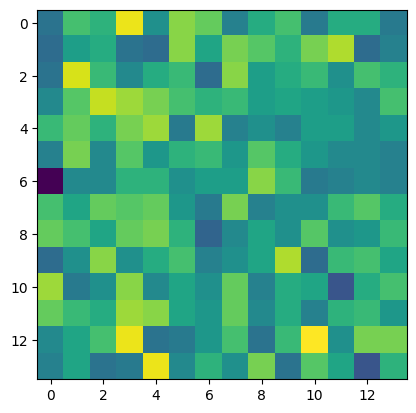

In [126]:
plt.imshow(dataset[2][0][0])

In [128]:
# Define a simple CNN model
class QuantumMNISTClassifier(nn.Module):
    def __init__(self):
        super(QuantumMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=32)  # (20 channels → 32 filters)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class QuantumMNISTClassifierV2(nn.Module):
    def __init__(self):
        super(QuantumMNISTClassifierV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (1 → 16 filters)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (16 → 32 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Downsamples to (7x7)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Fully connected layer
        self.fc2 = nn.Linear(64, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = QuantumMNISTClassifierV2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    correct, total = 0, 0
    
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/100, Loss: 2.2926, Accuracy: 7.50%
Epoch 2/100, Loss: 2.3355, Accuracy: 10.00%
Epoch 3/100, Loss: 2.3051, Accuracy: 7.50%
Epoch 4/100, Loss: 2.2815, Accuracy: 10.00%
Epoch 5/100, Loss: 2.3327, Accuracy: 10.00%
Epoch 6/100, Loss: 2.3030, Accuracy: 10.00%
Epoch 7/100, Loss: 2.3025, Accuracy: 10.00%
Epoch 8/100, Loss: 2.3179, Accuracy: 10.00%
Epoch 9/100, Loss: 2.3128, Accuracy: 10.00%
Epoch 10/100, Loss: 2.2954, Accuracy: 10.00%
Epoch 11/100, Loss: 2.2909, Accuracy: 10.00%
Epoch 12/100, Loss: 2.3150, Accuracy: 10.00%
Epoch 13/100, Loss: 2.3074, Accuracy: 10.00%
Epoch 14/100, Loss: 2.2906, Accuracy: 8.50%
Epoch 15/100, Loss: 2.2961, Accuracy: 10.00%
Epoch 16/100, Loss: 2.3125, Accuracy: 10.00%
Epoch 17/100, Loss: 2.2889, Accuracy: 10.00%
Epoch 18/100, Loss: 2.2977, Accuracy: 10.00%
Epoch 19/100, Loss: 2.3002, Accuracy: 10.00%
Epoch 20/100, Loss: 2.2948, Accuracy: 10.00%
Epoch 21/100, Loss: 2.3008, Accuracy: 10.00%
Epoch 22/100, Loss: 2.3021, Accuracy: 10.00%
Epoch 23/100, Loss: 2.

In [129]:
dataset = QuantumMNISTDataset(expanded_images_train, expanded_labels_train)
train_loader = data.DataLoader(dataset, batch_size=10, shuffle=True)

In [130]:
# Simpler CNN Model
class SimpleQuantumMNIST(nn.Module):
    def __init__(self):
        super(SimpleQuantumMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # (1 → 8 filters)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # (8 → 16 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample to (7x7)
        self.fc1 = nn.Linear(16 * 7 * 7, 32)  # Smaller FC layer
        self.fc2 = nn.Linear(32, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleQuantumMNIST()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Reduced learning rate

# Training loop
num_epochs = 50  # Increased epochs
for epoch in range(num_epochs):
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/50, Loss: 46.1614, Accuracy: 9.00%
Epoch 2/50, Loss: 46.1156, Accuracy: 7.50%
Epoch 3/50, Loss: 46.1092, Accuracy: 9.50%
Epoch 4/50, Loss: 46.1116, Accuracy: 10.00%
Epoch 5/50, Loss: 46.1389, Accuracy: 10.00%
Epoch 6/50, Loss: 46.1186, Accuracy: 10.00%
Epoch 7/50, Loss: 46.0907, Accuracy: 10.00%
Epoch 8/50, Loss: 46.0826, Accuracy: 10.00%
Epoch 9/50, Loss: 46.0824, Accuracy: 10.00%
Epoch 10/50, Loss: 46.0729, Accuracy: 10.00%
Epoch 11/50, Loss: 46.0860, Accuracy: 10.00%
Epoch 12/50, Loss: 46.0733, Accuracy: 10.00%
Epoch 13/50, Loss: 46.0711, Accuracy: 10.00%
Epoch 14/50, Loss: 46.0756, Accuracy: 10.00%
Epoch 15/50, Loss: 46.0691, Accuracy: 10.00%
Epoch 16/50, Loss: 46.0702, Accuracy: 10.00%
Epoch 17/50, Loss: 46.0613, Accuracy: 10.00%
Epoch 18/50, Loss: 46.0642, Accuracy: 10.00%
Epoch 19/50, Loss: 46.0690, Accuracy: 10.00%
Epoch 20/50, Loss: 46.0684, Accuracy: 10.00%
Epoch 21/50, Loss: 46.0587, Accuracy: 10.00%
Epoch 22/50, Loss: 46.0699, Accuracy: 10.00%
Epoch 23/50, Loss: 46.

In [ ]:
from torchvision import models

In [139]:
class QuantumMNISTCNN(nn.Module):
    def __init__(self):
        super(QuantumMNISTCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (14,14) → (14,14)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (14,14) → (14,14)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # (14,14) → (7,7)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (7,7) → (7,7)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)  # (7,7) → (3,3)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),  # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)  # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device
model = QuantumMNISTCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/50], Loss: 87.5746, Accuracy: 11.00%
Epoch [2/50], Loss: 95.2338, Accuracy: 9.00%
Epoch [3/50], Loss: 81.0913, Accuracy: 12.00%
Epoch [4/50], Loss: 85.3692, Accuracy: 13.50%
Epoch [5/50], Loss: 80.3143, Accuracy: 15.00%
Epoch [6/50], Loss: 81.1307, Accuracy: 15.00%
Epoch [7/50], Loss: 52.3378, Accuracy: 17.50%
Epoch [8/50], Loss: 50.9149, Accuracy: 16.00%
Epoch [9/50], Loss: 49.5950, Accuracy: 21.00%
Epoch [10/50], Loss: 49.3038, Accuracy: 16.50%
Epoch [11/50], Loss: 48.6171, Accuracy: 19.00%
Epoch [12/50], Loss: 47.9727, Accuracy: 17.50%
Epoch [13/50], Loss: 47.3879, Accuracy: 22.50%
Epoch [14/50], Loss: 47.2824, Accuracy: 20.50%
Epoch [15/50], Loss: 46.5852, Accuracy: 21.00%
Epoch [16/50], Loss: 46.0945, Accuracy: 20.50%
Epoch [17/50], Loss: 46.2697, Accuracy: 17.50%
Epoch [18/50], Loss: 46.0547, Accuracy: 18.50%
Epoch [19/50], Loss: 45.8720, Accuracy: 20.50%
Epoch [20/50], Loss: 45.3220, Accuracy: 23.50%
Epoch [21/50], Loss: 45.1277, Accuracy: 22.50%
Epoch [22/50], Loss: 44

### Vanilla Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

def MyModel():
    """Initializes and returns a simple Keras model for classification."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),  # flatten input (no Conv layers here)
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Initialize two models: one for quantum features, one for original features
q_model = MyModel()
c_model = MyModel()


In [ ]:
# Train on quantum features
q_history = q_model.fit(
    q_train_images, train_labels[:len(q_train_images)],  # use corresponding labels for the processed subset
    validation_data=(q_test_images, test_labels[:len(q_test_images)]),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

# Train on original images (baseline)
c_history = c_model.fit(
    train_images[:len(q_train_images)], train_labels[:len(q_train_images)],  # use same number of samples for fair comparison
    validation_data=(test_images[:len(q_test_images)], test_labels[:len(q_test_images)]),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


## Combined

In [ ]:
fully_combined = None

[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filte

In [154]:
def append_npy_files(final_file, new_files):
    if os.path.exists(final_file):
        existing_data = np.load(final_file, allow_pickle=True)
    else:
        existing_data = np.array([])  # Start with an empty array
    
    for new_file in new_files:
        new_data = np.load(new_file, allow_pickle=True)
        
        # Concatenate along the first axis (assuming shape consistency)
        if existing_data.size == 0:
            existing_data = new_data
        else:
            existing_data = np.concatenate((existing_data, new_data), axis=0)
    
    np.save(final_file, existing_data)
    print(f"Appended {len(new_files)} files. Final dataset shape: {existing_data.shape}")

[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 4
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filte

In [156]:
new_files = ["/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_images_cont.npy"]

In [157]:
for i in range(10, 51):
    new_files.append("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_images_cont_" + str(i) + ".npy")

In [159]:
append_npy_files("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_images_cont__final_concat.npy", new_files)

Appended 42 files. Final dataset shape: (42, 14, 14, 20)


In [160]:
images_final_concat = np.load("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_images_cont__final_concat.npy")

In [161]:
images_final_concat.shape

(42, 14, 14, 20)

In [162]:
new_files = ["/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_labels_cont.npy"]

In [163]:
for i in range(10, 51):
    new_files.append("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_labels_cont_" + str(i) + ".npy")

In [164]:
append_npy_files("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_labels_cont__final_concat.npy", new_files)

Appended 42 files. Final dataset shape: (42,)


In [165]:
train_labels[:42]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8],
      dtype=uint8)

In [166]:
np.save("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_1_train_labels_cont__final_concat__2.npy", train_labels[:42])

# Direct on main dataset

In [167]:
class QuantumMNISTCNN(nn.Module):
    def __init__(self):
        super(QuantumMNISTCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (14,14) → (14,14)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (14,14) → (14,14)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # (14,14) → (7,7)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (7,7) → (7,7)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)  # (7,7) → (3,3)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),  # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)  # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
class QuantumMNISTClassifierV2(nn.Module):
    def __init__(self):
        super(QuantumMNISTClassifierV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (1 → 16 filters)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (16 → 32 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Downsamples to (7x7)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Fully connected layer
        self.fc2 = nn.Linear(64, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [191]:
# CNN Baseline
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (1, 28, 28) → (32, 28, 28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (32, 28, 28) → (64, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)  # (64, 28, 28) → (64, 14, 14)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (64, 14, 14) → (128, 14, 14)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128, 14, 14) → (128, 7, 7)
        
        # self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc1 = nn.Linear(1152, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.4)  # 🔥 Prevent overfitting
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool2(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten (128 * 7 * 7 → 6272)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device
model_1 = QuantumMNISTCNN().to(device)
# model_1 = QuantumMNISTClassifierV2().to(device)
# model_1 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

accuracies_type1__5_53 = []
losses_type1__5_53 = []

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    counter_i = 0
    
    for images, labels in train_loader:
        if counter_i < 53:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model_1(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        counter_i += 1

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    accuracies_type1__5_53.append(accuracy)
    losses_type1__5_53.append(running_loss)

Epoch [1/100], Loss: 91.4529, Accuracy: 10.00%
Epoch [2/100], Loss: 96.6421, Accuracy: 7.50%
Epoch [3/100], Loss: 78.8586, Accuracy: 15.00%
Epoch [4/100], Loss: 100.4291, Accuracy: 9.00%
Epoch [5/100], Loss: 85.9963, Accuracy: 12.00%
Epoch [6/100], Loss: 80.8117, Accuracy: 10.00%
Epoch [7/100], Loss: 53.6827, Accuracy: 13.00%
Epoch [8/100], Loss: 51.6797, Accuracy: 19.50%
Epoch [9/100], Loss: 50.5917, Accuracy: 21.00%
Epoch [10/100], Loss: 49.6739, Accuracy: 17.50%
Epoch [11/100], Loss: 48.3953, Accuracy: 17.50%
Epoch [12/100], Loss: 47.8843, Accuracy: 24.50%
Epoch [13/100], Loss: 47.6239, Accuracy: 20.00%
Epoch [14/100], Loss: 47.0740, Accuracy: 19.50%
Epoch [15/100], Loss: 46.8589, Accuracy: 19.00%
Epoch [16/100], Loss: 46.4427, Accuracy: 23.50%
Epoch [17/100], Loss: 45.9707, Accuracy: 16.50%
Epoch [18/100], Loss: 47.0305, Accuracy: 18.50%
Epoch [19/100], Loss: 44.8558, Accuracy: 20.50%
Epoch [20/100], Loss: 45.6104, Accuracy: 22.00%
Epoch [21/100], Loss: 45.0056, Accuracy: 22.00%
Ep

In [197]:
accuracies_type1__5_quanv = [19.642857142857142,
 19.047619047619047,
 27.976190476190474,
 32.73809523809524,
 22.61904761904762,
 33.333333333333336,
 29.761904761904763,
 34.523809523809526,
 27.976190476190474,
 31.547619047619047,
 35.11904761904762,
 35.714285714285715,
 36.30952380952381,
 34.523809523809526,
 38.095238095238095,
 36.904761904761905,
 36.904761904761905,
 36.30952380952381,
 36.30952380952381,
 38.095238095238095,
 37.5,
 36.30952380952381,
 39.285714285714285,
 42.857142857142854,
 44.04761904761905,
 47.023809523809526,
 49.404761904761905,
 38.69047619047619,
 47.023809523809526,
 47.61904761904762,
 48.80952380952381,
 49.404761904761905,
 54.166666666666664,
 54.166666666666664,
 63.095238095238095,
 62.5,
 54.166666666666664,
 58.92857142857143,
 63.69047619047619,
 67.85714285714286,
 59.523809523809526,
 73.80952380952381,
 67.26190476190476,
 67.26190476190476,
 67.26190476190476,
 69.04761904761905,
 58.92857142857143,
 66.66666666666667,
 66.66666666666667,
 72.02380952380952,
 76.19047619047619,
 73.80952380952381,
 73.21428571428571,
 75.5952380952381,
 77.97619047619048,
 72.02380952380952,
 66.07142857142857,
 64.28571428571429,
 63.69047619047619,
 75.5952380952381,
 78.57142857142857,
 78.57142857142857,
 75.5952380952381,
 83.33333333333333,
 73.80952380952381,
 75.5952380952381,
 68.45238095238095,
 77.38095238095238,
 66.07142857142857,
 79.16666666666667,
 85.11904761904762,
 82.14285714285714,
 76.19047619047619,
 82.73809523809524,
 87.5,
 78.57142857142857,
 86.9047619047619,
 88.69047619047619,
 89.88095238095238,
 89.28571428571429,
 85.11904761904762,
 77.38095238095238,
 82.14285714285714,
 85.71428571428571,
 89.28571428571429,
 90.47619047619048,
 94.04761904761905,
 89.88095238095238,
 89.88095238095238,
 92.85714285714286,
 90.47619047619048,
 94.04761904761905,
 97.02380952380952,
 98.80952380952381,
 98.80952380952381,
 98.80952380952381,
 98.21428571428571,
 99.4047619047619,
 99.4047619047619,
 98.21428571428571]

In [198]:
accuracies_type2__5_quanv = [15.566037735849056,
 20.28301886792453,
 23.11320754716981,
 21.22641509433962,
 21.22641509433962,
 17.92452830188679,
 22.641509433962263,
 22.169811320754718,
 18.867924528301888,
 20.754716981132077,
 24.056603773584907,
 20.28301886792453,
 19.339622641509433,
 24.056603773584907,
 27.830188679245282,
 25.943396226415093,
 25.943396226415093,
 27.830188679245282,
 30.18867924528302,
 26.41509433962264,
 22.641509433962263,
 28.77358490566038,
 25.0,
 22.641509433962263,
 25.943396226415093,
 24.528301886792452,
 30.660377358490567,
 22.169811320754718,
 27.358490566037737,
 29.71698113207547,
 29.71698113207547,
 26.88679245283019,
 25.0,
 29.245283018867923,
 28.77358490566038,
 28.77358490566038,
 27.358490566037737,
 27.830188679245282,
 28.77358490566038,
 26.41509433962264,
 26.88679245283019,
 28.77358490566038,
 28.30188679245283,
 26.41509433962264,
 29.71698113207547,
 28.77358490566038,
 29.71698113207547,
 30.660377358490567,
 29.71698113207547,
 27.358490566037737,
 29.245283018867923,
 25.943396226415093,
 27.830188679245282,
 28.77358490566038,
 28.30188679245283,
 29.245283018867923,
 29.71698113207547,
 27.830188679245282,
 29.71698113207547,
 29.245283018867923,
 29.71698113207547,
 30.660377358490567,
 27.830188679245282,
 30.18867924528302,
 26.41509433962264,
 28.30188679245283,
 28.77358490566038,
 29.245283018867923,
 29.71698113207547,
 27.830188679245282,
 29.71698113207547,
 30.660377358490567,
 26.41509433962264,
 29.245283018867923,
 29.71698113207547,
 28.77358490566038,
 28.77358490566038,
 27.830188679245282,
 28.77358490566038,
 29.71698113207547,
 28.77358490566038,
 29.71698113207547,
 30.18867924528302,
 30.18867924528302,
 28.77358490566038,
 30.660377358490567,
 28.77358490566038,
 29.71698113207547,
 29.71698113207547,
 29.71698113207547,
 29.245283018867923,
 27.830188679245282,
 29.245283018867923,
 28.30188679245283,
 28.77358490566038,
 30.660377358490567,
 29.71698113207547,
 30.18867924528302,
 29.71698113207547,
 30.18867924528302]

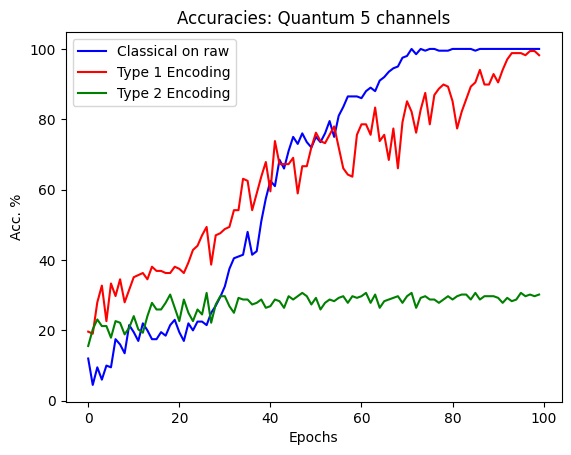

In [201]:
x = [i for i in range(100)]
y1 = accuracies_type1__5
y2 = accuracies_type1__5_quanv
y3 = accuracies_type2__5_quanv

plt.plot(x, y1, linestyle='-', color='b', label="Classical on raw")  # Blue line
plt.plot(x, y2, linestyle='-', color='r', label="Type 1 Encoding")  # Blue line
plt.plot(x, y3, linestyle='-', color='g', label="Type 2 Encoding")  # Blue line

plt.xlabel("Epochs")
plt.ylabel("Acc. %")
plt.title("Accuracies: Quantum 5 channels")
plt.legend()

plt.show()

In [202]:
accuracies_type1__20_quanv = [4.761904761904762,
 7.142857142857143,
 26.19047619047619,
 21.428571428571427,
 30.952380952380953,
 19.047619047619047,
 28.571428571428573,
 38.095238095238095,
 69.04761904761905,
 76.19047619047619,
 73.80952380952381,
 80.95238095238095,
 100.0,
 97.61904761904762,
 95.23809523809524,
 97.61904761904762,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [203]:
accuracies_type2__20_quanv = [9.433962264150944,
 13.20754716981132,
 20.754716981132077,
 16.9811320754717,
 20.754716981132077,
 18.867924528301888,
 15.09433962264151,
 22.641509433962263,
 16.9811320754717,
 22.641509433962263,
 22.641509433962263,
 18.867924528301888,
 18.867924528301888,
 18.867924528301888,
 9.433962264150944,
 20.754716981132077,
 16.9811320754717,
 13.20754716981132,
 16.9811320754717,
 15.09433962264151,
 11.320754716981131,
 13.20754716981132,
 15.09433962264151,
 11.320754716981131,
 18.867924528301888,
 16.9811320754717,
 15.09433962264151,
 20.754716981132077,
 24.528301886792452,
 37.735849056603776,
 47.16981132075472,
 37.735849056603776,
 58.490566037735846,
 71.69811320754717,
 81.13207547169812,
 90.56603773584905,
 92.45283018867924,
 94.33962264150944,
 90.56603773584905,
 98.11320754716981,
 100.0,
 98.11320754716981,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

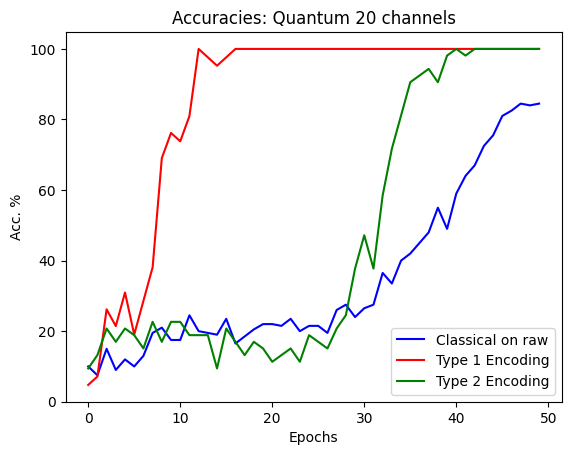

In [208]:
x = [i for i in range(50)]
y1 = accuracies_type1__5_53[:50]
y2 = accuracies_type1__20_quanv
y3 = accuracies_type2__20_quanv

plt.plot(x, y1, linestyle='-', color='b', label="Classical on raw")  # Blue line
plt.plot(x, y2, linestyle='-', color='r', label="Type 1 Encoding")  # Blue line
plt.plot(x, y3, linestyle='-', color='g', label="Type 2 Encoding")  # Blue line

plt.xlabel("Epochs")
plt.ylabel("Acc. %")
plt.title("Accuracies: Quantum 20 channels")
plt.legend()

plt.show()